<a href="https://colab.research.google.com/github/AchinthaThennakoon/L4S2-FYP-UOM/blob/main/measuring_cnn_model_performance/measure_performance(extended_augementation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

In [3]:
import pandas as pd

In [4]:
import pickle

# loading data set

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/imgs'

In [7]:
data_dir = pathlib.Path(dataset_path)
data_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/imgs')

In [8]:
train_ds,val_ds =  keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    seed=123,
    batch_size=32,
    image_size=(224, 224),
    )

Found 3821 files belonging to 2 classes.
Using 3057 files for training.
Using 764 files for validation.


In [9]:
class_names = train_ds.class_names
class_names

['Blight', 'Gray_Leaf_Spot']

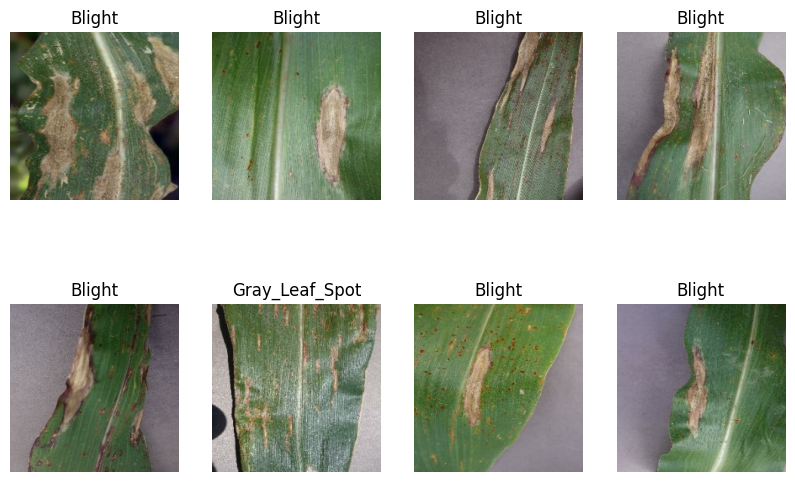

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## divide validation set to test & validation

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))


Number of validation batches: 24


In [12]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

In [13]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 20
Number of test batches: 4


# parameters and augmentations

In [14]:
resize_and_rescale = keras.Sequential([
  keras.layers.Resizing(224, 224),
  keras.layers.Rescaling(1./127.5, offset=-1),
])

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(0.2),
  #tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
  tf.keras.layers.RandomBrightness(factor=0.2)
])

In [16]:
no_of_classes = 2

In [17]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [19]:
epochs = 150

# Measure performance vs Layers

## model

In [20]:
def create_model(depth):
    model = tf.keras.models.Sequential()
    model.add(resize_and_rescale)
    model.add(data_augmentation)

    model.add(layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    for _ in range(depth - 1):
        model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(no_of_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

## Early stopping

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    monitor='val_loss',
                                                    mode='min',
                                                    patience=5,
                                                    restore_best_weights=True
                                                    )

## Train the Models

In [22]:
depths = [1,2, 3, 4, 5, 6, 7, 8]  # Different depths to test
results = []

In [ ]:
for depth in depths:
      print(f"Training model with depth {depth}")
      model = create_model(depth)

      history = model.fit(
                          train_ds,
                          batch_size=BATCH_SIZE,
                          validation_data=validation_dataset,
                          verbose=1,
                          epochs=epochs,
                          callbacks=[early_stopping]
                          )
      # Evaluate the model
      test_loss, test_accuracy = model.evaluate(test_dataset)
      print(f'Test accuracy: {test_accuracy}')

      results.append((depth, history.history))

Training model with depth 1
Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


96/96 [==============================] - 294s 3s/step - loss: 127.4358 - accuracy: 0.5126 - val_loss: 37.6433 - val_accuracy: 0.4528
Epoch 2/150
96/96 [==============================] - 16s 155ms/step - loss: 0.6923 - accuracy: 0.5757 - val_loss: 57.5960 - val_accuracy: 0.4528
Epoch 3/150
96/96 [==============================] - 15s 150ms/step - loss: 0.6860 - accuracy: 0.5757 - val_loss: 60.6201 - val_accuracy: 0.4528
Epoch 4/150
96/96 [==============================] - 15s 151ms/step - loss: 0.6847 - accuracy: 0.5774 - val_loss: 47.8525 - val_accuracy: 0.4528
Epoch 5/150
96/96 [==============================] - 18s 175ms/step - loss: 0.6832 - accuracy: 0.5767 - val_loss: 39.7867 - val_accuracy: 0.4528
Epoch 6/150
4/4 [==============================] - 0s 98ms/step - loss: 41.5304 - accuracy: 0.3984
Test accuracy: 0.3984375
Training model with depth 2
Epoch 1/150
96/96 [==============================] - 21s 184ms/step - loss: 1.6325 - accuracy: 0.5679 - val_loss: 0.6929 - val_accuracy

In [ ]:
# Save results
with open('model_performance.pkl', 'wb') as f:
    pickle.dump(results, f)

## analyze the performance

In [ ]:
# Load results
with open('model_performance.pkl', 'rb') as f:
    results = pickle.load(f)

In [ ]:
# Plot training and validation loss for each depth
plt.figure(figsize=(14, 7))
for depth, history in results:
    plt.plot(history['loss'], label=f'Depth {depth} Train Loss')
    plt.plot(history['val_loss'], label=f'Depth {depth} Val Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Plot training and validation loss for each depth seperatly

for depth, history in results:
    plt.figure(figsize=(14, 7))
    plt.plot(history['loss'], label=f'Depth {depth} Train Loss')
    plt.plot(history['val_loss'], label=f'Depth {depth} Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Validation Loss for depth:{depth}')
    plt.show()

In [ ]:
# Plot training and validation accuracy for each depth
plt.figure(figsize=(14, 7))
for depth, history in results:
    plt.plot(history['accuracy'], label=f'Depth {depth} Train Acc')
    plt.plot(history['val_accuracy'], label=f'Depth {depth} Val Acc')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
for depth, history in results:
  plt.figure(figsize=(7, 3))
  plt.plot(history['accuracy'], label=f'Depth {depth} Train Acc')
  plt.plot(history['val_accuracy'], label=f'Depth {depth} Val Acc')

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title(f'Training and Validation Accuracy for  depth:{depth}')
  plt.show()